In [53]:
import pandas as pd
from sklearn import datasets
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = datasets.fetch_olivetti_faces()
data_oliv = pd.DataFrame(data.data)
data_num = data_oliv.to_numpy()
data_oliv.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.665289,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554


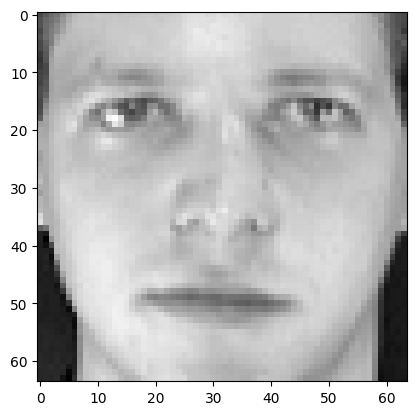

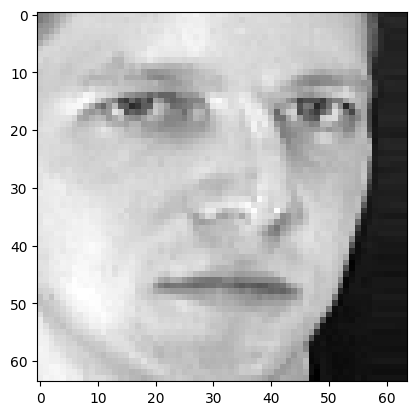

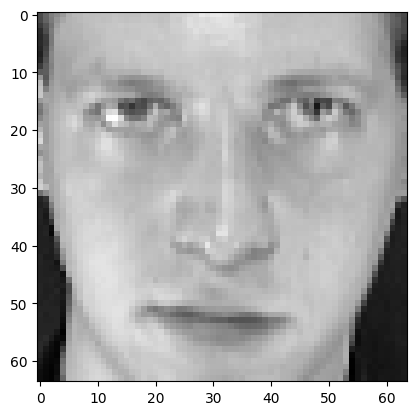

In [54]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1234)

def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

for i in range(3):
    show_image(data_num[i,:].reshape(64,64))

FORWARD DIFFUSION

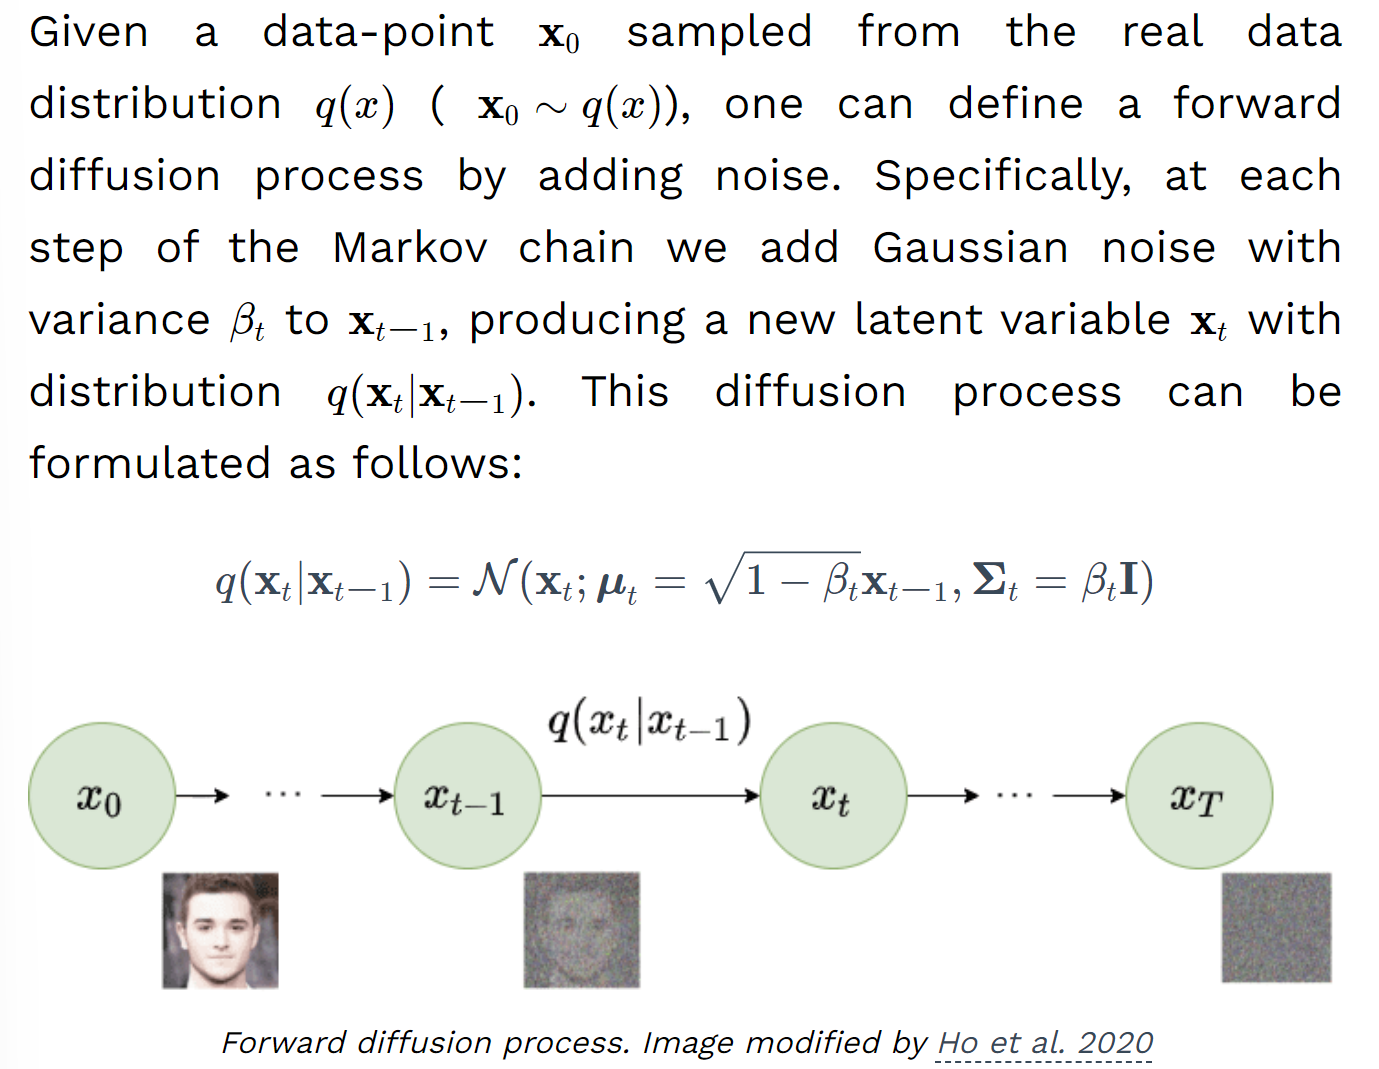

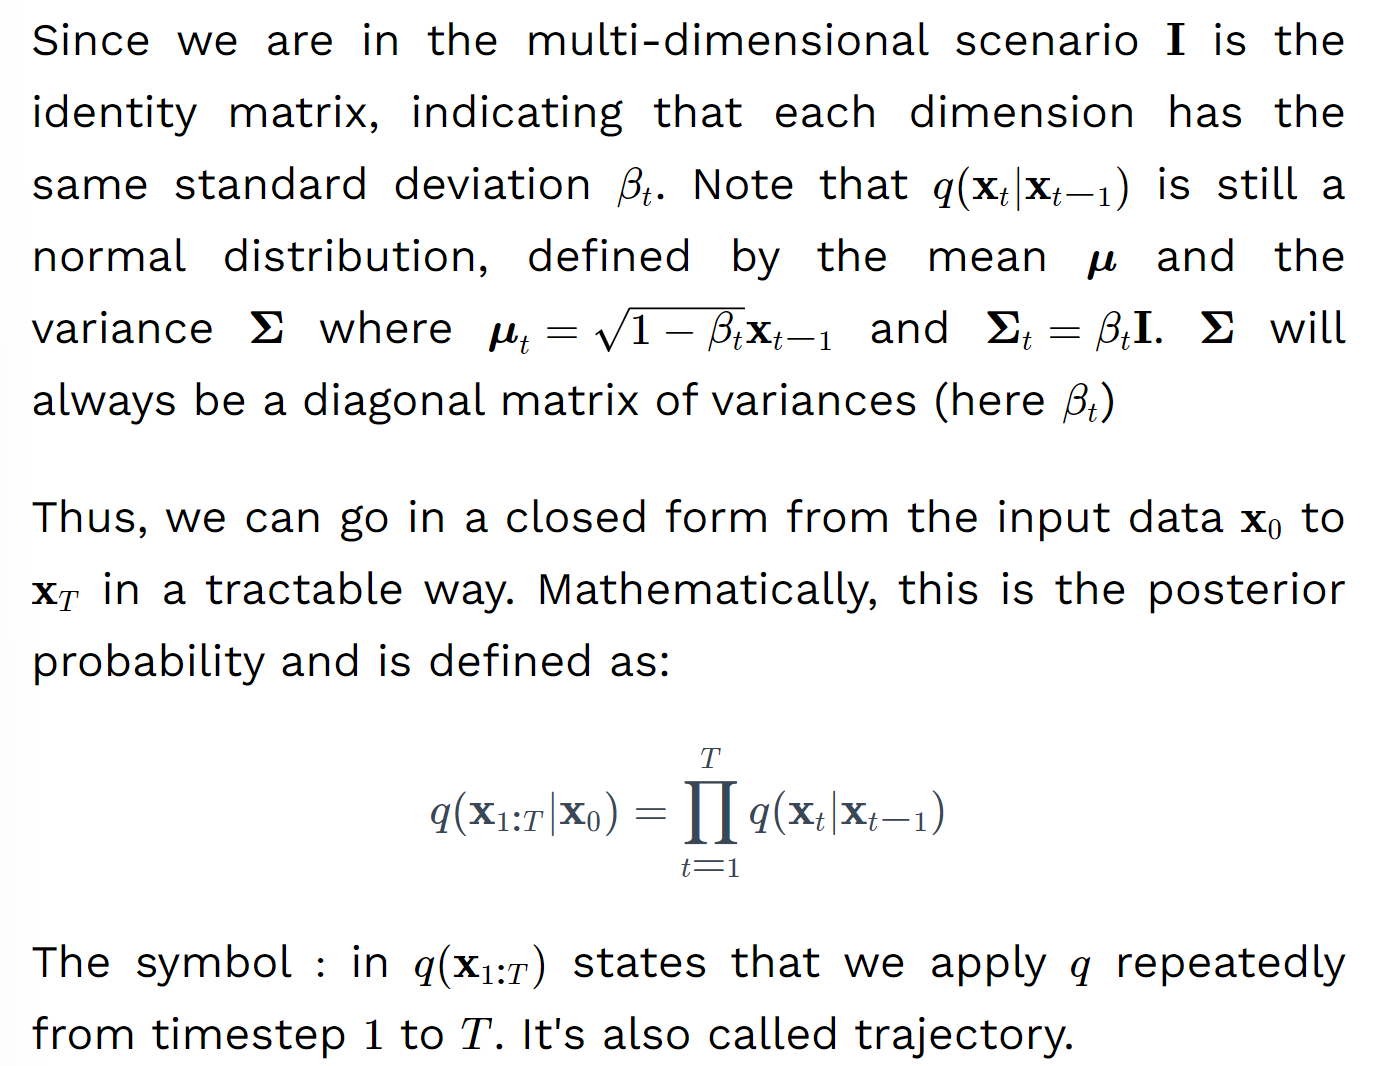

Now trick 

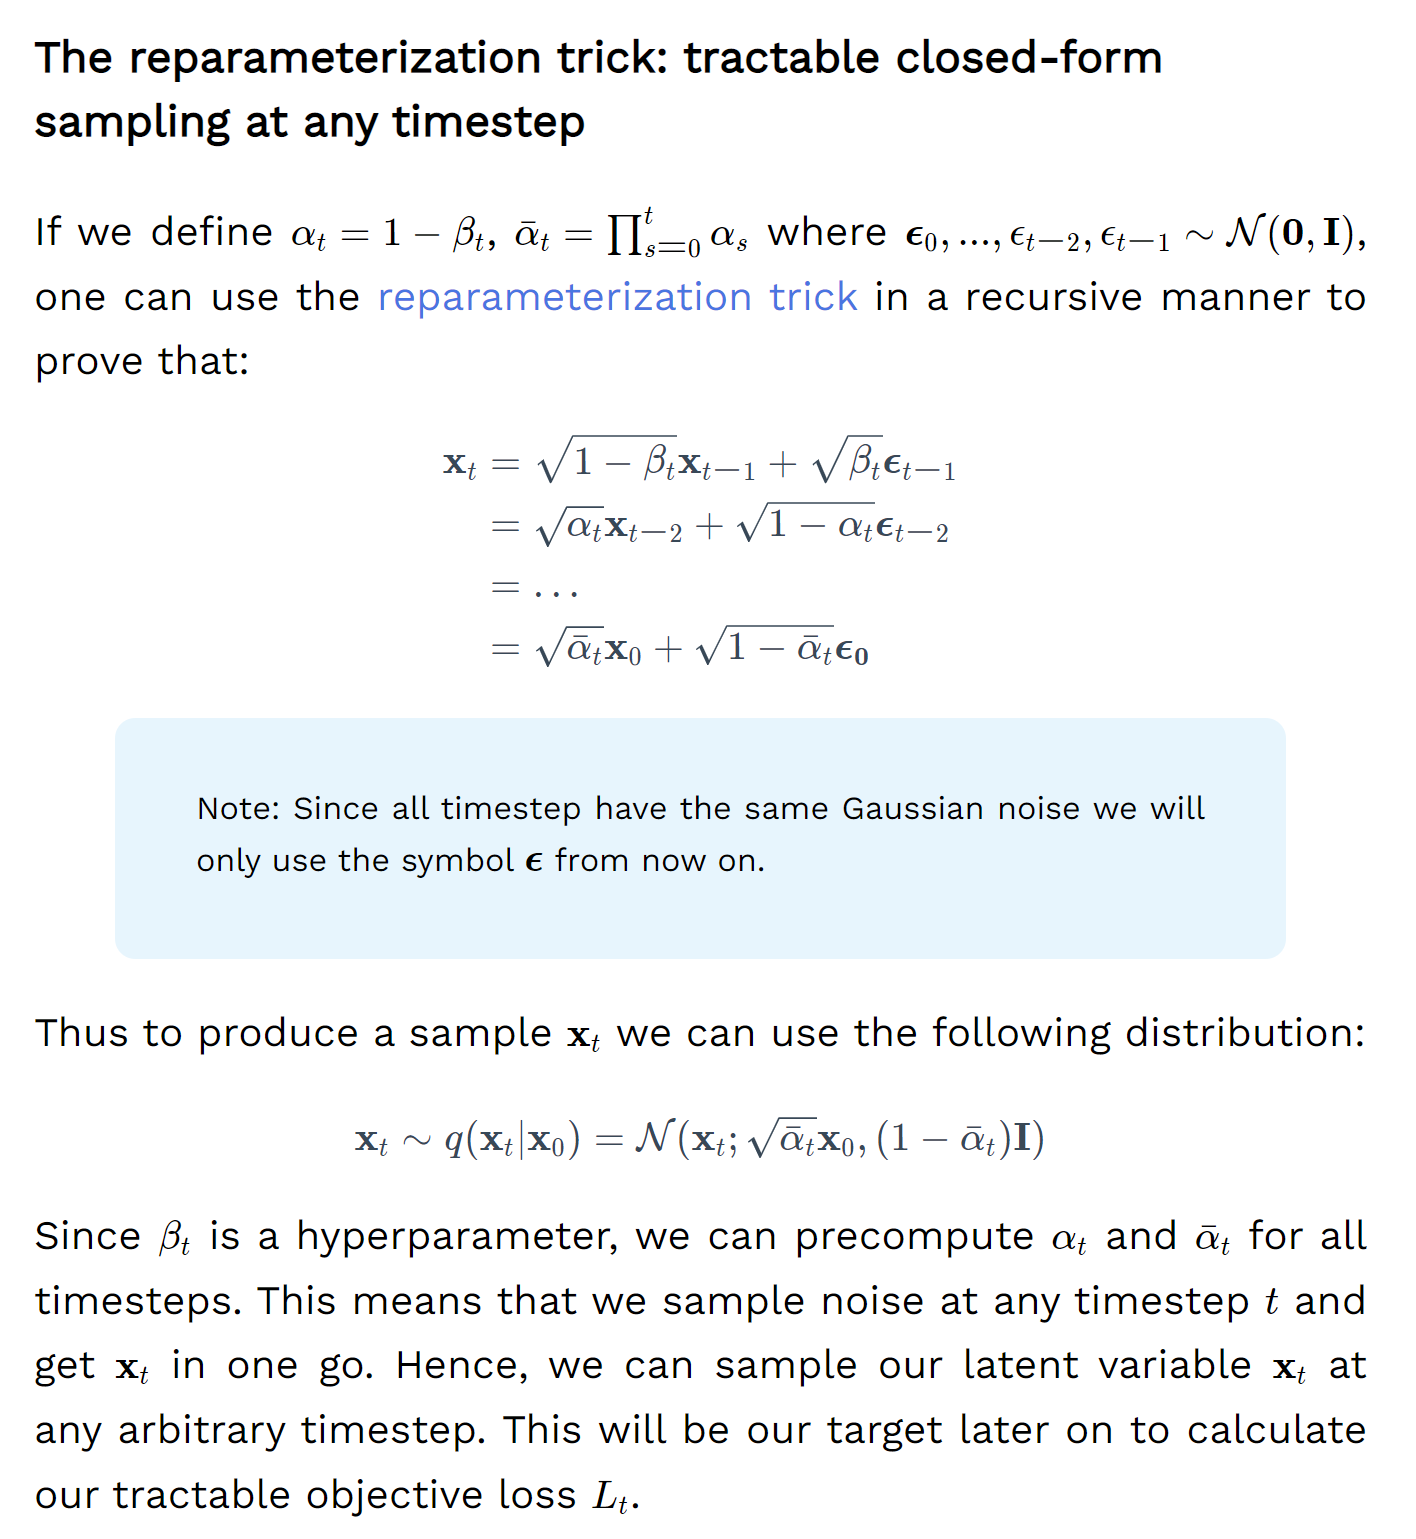

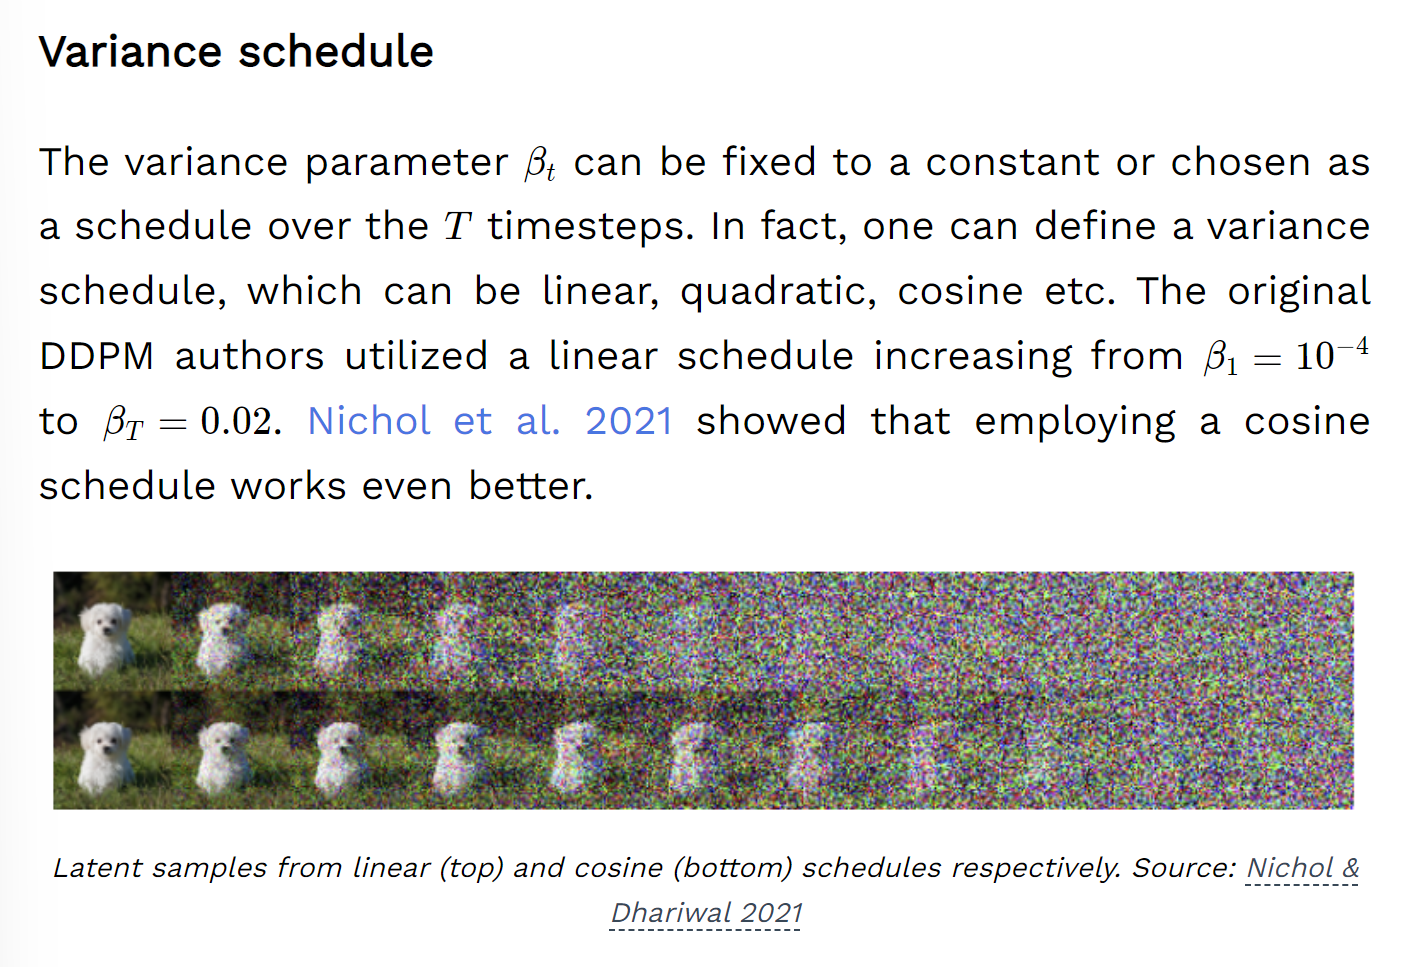



In [55]:
import torch.nn.functional as F
import torch

#This is the function that will be used to generate the beta values for the diffusion process
def beta(start, stop, timesteps):
    return torch.linspace(start,stop,timesteps)

#Alphas depend on the beta values
start = 0.01
stop = 0.02
timesteps = 300
betas = beta(start, stop, timesteps)
alphas = 1. - betas
alpha_bar = torch.cumprod(alphas, axis=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar= torch.sqrt(1. - alpha_bar)
rec_sqrt_alpha_bar = 1. / sqrt_alpha_bar
alpha_bar_prev = torch.cat([torch.tensor([1.]), alpha_bar[:-1]])
var = betas*(1. - alpha_bar_prev) / (1. - alpha_bar) #variance of the diffusion process at each timestep t


def get_vals(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    
    Args:
        vals (torch.Tensor): A tensor containing the values from which to gather elements.
        t (torch.Tensor): A tensor containing the indices of the elements to be gathered.
        x_shape (tuple): The shape of the input tensor for which the gathered values will be used.
        
    Returns:
        torch.Tensor: A tensor containing the gathered elements from vals, reshaped to match the input tensor shape.
    """
    # Gather the values from 'vals' using the indices provided in 't'
    # We use gather() along the last dimension (-1) of the vals tensor
    #convert t to long
    t = t.long()
    # print("vals",vals.shape)
    gathered_vals = vals.gather(-1, t)

    # Calculate the output shape based on the input tensor shape
    # We want to keep the batch size and add extra dimensions with size 1 to match the input tensor shape
    out_shape = (t.shape[0],) + ((1,) * (len(x_shape) - 1))
    # print("out",out_shape)

    # Reshape the gathered values tensor to match the output shape and move it to the same device as 't'
    reshaped_vals = gathered_vals.reshape(out_shape)
    # print("re" , reshaped_vals.shape)

    return reshaped_vals


def q_xt_x0(x0,t,device = "cpu"):

    t = torch.tensor(t, dtype=torch.float32, device=device)
    # t = t.unsqueeze(0)
    # print("t",t.shape)
    # print("x0",x0.shape)
    #Here we are calculating the mean and variance of the diffusion process
    mean_mul = get_vals(sqrt_alpha_bar, t, x0.shape)
    mean = mean_mul * x0

    noise = torch.randn_like(x0)
    var_mul = get_vals(sqrt_one_minus_alpha_bar, t, x0.shape)
    var = var_mul * noise

    #We are adding the mean and variance to get the final value of the diffusion process
    x_t = mean + var

    return x_t,noise


def num_to_torch(x):
    #lets convert the data to tensors
    x = torch.from_numpy(x).float()

    #lets reshape the data into 4d array
    x = x.reshape(1, 1, 64, 64)

    return x

def torch_to_num(x):
    #lets reshape the data into 2d array
    x = x.reshape(64, 64)

    return x

def plot_image(x):
    #lets convert the data to numpy
    x = x.detach().numpy()

    #lets reshape the data into 2d array
    x = x.reshape(64, 64)

    #lets plot the data
    show_image(x)


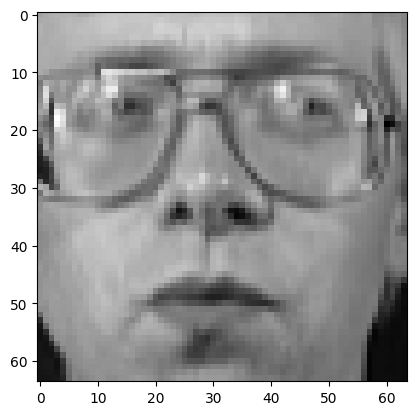

C:\Users\Suman\AppData\Local\Temp\ipykernel_25056\714109008.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, device=device)


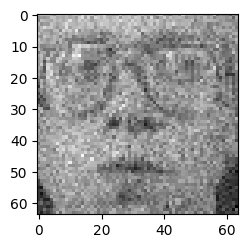

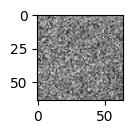

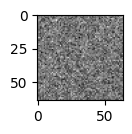

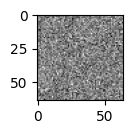

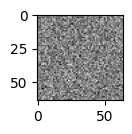

In [56]:
# Assuming data_num and num_to_torch are defined

# Simulate forward diffusion
image = num_to_torch(data_num[12, :])
T = 300
plot_image(image)

def plot_forward(image, T, stepsize):
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    for idx, step in enumerate(range(0, T, stepsize)):
        t = torch.Tensor([step]).type(torch.int64)
        # Remove overlapping axes explicitly
        for ax in plt.gcf().axes:
            if ax.get_position().overlaps(plt.gca().get_position()):
                ax.remove()
        plt.subplot(1, 5, idx + 1)
        image,noise = q_xt_x0(image, t)
        plot_image(image)

    return image

image = plot_forward(image, 300, 60)
im_num = torch_to_num(image)

In [57]:
im_num

tensor([[ 1.2424, -1.5774,  1.0628,  ..., -0.7740, -1.1335,  0.4974],
        [-0.2523,  1.5286,  0.7395,  ..., -1.1342,  0.0056,  0.1065],
        [-0.8933, -1.5735, -0.6982,  ...,  0.1469,  1.9296,  2.9315],
        ...,
        [-0.7912,  0.0564,  0.1814,  ..., -0.2493,  0.2340, -0.6859],
        [ 0.9889,  0.9262, -1.0218,  ..., -1.1069,  1.1810, -0.4099],
        [ 0.2111, -1.0058, -0.5301,  ..., -0.5101, -1.2678,  0.5019]])

In [58]:
data_num[12,:].reshape(64,64)

array([[0.6570248 , 0.677686  , 0.6983471 , ..., 0.55785125, 0.57024795,
        0.54545456],
       [0.677686  , 0.6859504 , 0.69008267, ..., 0.57438016, 0.5785124 ,
        0.5413223 ],
       [0.6983471 , 0.6818182 , 0.6818182 , ..., 0.60330576, 0.58677685,
        0.5495868 ],
       ...,
       [0.1446281 , 0.15289256, 0.1570248 , ..., 0.10330579, 0.11157025,
        0.10743801],
       [0.14049587, 0.1446281 , 0.14876033, ..., 0.10743801, 0.11157025,
        0.10743801],
       [0.14049587, 0.14049587, 0.1446281 , ..., 0.11570248, 0.11570248,
        0.10330579]], dtype=float32)

In [59]:
nn.Conv2d?

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

In [60]:
# import torch
# import torch.nn as nn
# import math





# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(
#             half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings


# class Unet(nn.Module):
#     def __init__(self):
#         super(Unet, self).__init__()

#         time_emb_dim = 32

#         # Time embedding
#         self.time_mlp = nn.Sequential(
#             SinusoidalPositionEmbeddings(time_emb_dim),
#             nn.Linear(time_emb_dim, time_emb_dim),
#             nn.ReLU()
#         )

        
#         # Left side (contracting path)
#         self.conv1 = nn.Conv2d(
#             in_channels=1, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(
#             in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(
#             in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(
#             in_channels=256, out_channels=512, kernel_size=3, padding=1)

#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         #upsampling path
#         self.conv5 = nn.ConvTranspose2d(
#             in_channels=512, out_channels=256, kernel_size=2, stride=2)
#         self.conv6 = nn.ConvTranspose2d(
#             in_channels=256, out_channels=128, kernel_size=2, stride=2)
#         self.conv7 = nn.ConvTranspose2d(
#             in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
#         self.conv8 = nn.ConvTranspose2d(
#             in_channels=64, out_channels=1, kernel_size=3,padding=1)

#     def forward(self, image,t):

#         #forward pass for Left side
#        #downsampling path
#         x1 = F.selu(self.conv1(image))
#         x1 = self.maxpool(x1)
#         x2 = F.selu(self.conv2(x1))
#         x2 = self.maxpool(x2)
#         x3 = F.selu(self.conv3(x2))
#         x3 = self.maxpool(x3)
#         x4 = F.selu(self.conv4(x3))

#         time_emb = self.time_emb(t)
#         time_emb = time_emb.view(-1, x4.size(1), 1, 1)
#         x4 = x4 + time_emb


#         #upsampling path
#         x5 = F.selu(self.conv5(x4))
#         x5 = self.maxpool(x5)
#         x6 = F.selu(self.conv6(x5))
#         x6 = self.maxpool(x6)
#         x7 = F.selu(self.conv7(x6))
        

#         time_emb = self.time_emb(t)
#         time_emb = time_emb.view(-1, x7.size(1), 1, 1)
#         x = x7 + time_emb
#         x = F.interpolate(x, scale_factor=2, mode='bilinear',
#                           align_corners=False)
        
#         x = self.conv8(x)


        
#         return x



    
# model = Unet()
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# model


In [61]:
#Lets build a simple unet model, input we pass is a 1d array of 4096 values and output is also a 1d array of 4096 values

# import math

# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(
#             half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import summary


# class UNet(nn.Module):

#     def __init__(self):
#         super(UNet, self).__init__()

#         time_emb_dim = 32

#         # Time embedding
#         self.time_mlp = nn.Sequential(
#             SinusoidalPositionEmbeddings(time_emb_dim),
#             nn.Linear(time_emb_dim, time_emb_dim),
#             nn.ReLU()
#         )

#         #downsampling path
#         self.conv1 = nn.Conv2d(
#             in_channels=1, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(
#             in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(
#             in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(
#             in_channels=256, out_channels=512, kernel_size=3, padding=1)
        

#         #upsampling path
#         self.conv5 = nn.ConvTranspose2d(
#             in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)
#         self.conv6 = nn.ConvTranspose2d(
#             in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)
#         self.conv7 = nn.ConvTranspose2d(
#             in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)
#         self.conv8 = nn.ConvTranspose2d(
#             in_channels=64, out_channels=1, kernel_size=3, padding=1)

#     def forward(self, x,t):

#         #downsampling path
#         x1 = F.selu(self.conv1(x))
#         x1_pool = F.max_pool2d(x1, 2)

#         x2 = F.selu(self.conv2(x1_pool))
#         x2_pool = F.max_pool2d(x2, 2)

#         x3 = F.selu(self.conv3(x2_pool))
#         x3_pool = F.max_pool2d(x3, 2)

#         x4 = F.selu(self.conv4(x3_pool))

#         time_emb = self.time_mlp(t)
#         time_emb = time_emb.view(x4.size(0), x4.size(1), 1, 1)
#         x4 = x4 + time_emb

#         #upsampling path
#         x5 = F.selu(self.conv5(x4))
#         x6 = F.selu(self.conv6(x5))
#         x7 = F.selu(self.conv7(x6))

#         time_emb = self.time_mlp(t)
#         time_emb = time_emb.view(x7.size(0), x7.size(1), 1, 1)
#         x7 = x4 + time_emb
#         # time_emb = self.time_mlp(t)
#         # time_emb = time_emb.view(x7.size(0), -1, 1, 1)
#         # x = x7 + time_emb
#         # x = F.interpolate(x, scale_factor=2, mode='bilinear',
#         #                   align_corners=False)
#         out = F.selu(self.conv8(x7))

#         return out


# #lets create a model object
# model = UNet()

# # Move the model to the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Change the first dimension to match the batch size
# t = torch.rand(2, 1, device=device).unsqueeze(1)

# summary(model, input_size=[(1, 64, 64), (1,)],
#         batch_size=2)


In [62]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(
            half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1],
                                    time_emb_dim)
                                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True)
                                  for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


Num params:  62437601


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [63]:
# import torch
# from torch import nn
# import math


# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(
#             half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings


# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels, time_emb_dim):
#         super(DoubleConv, self).__init__()
#         self.time_mlp = nn.Linear(time_emb_dim, out_channels)
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x, t):
#         time_emb = self.time_mlp(t)
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         x = x + time_emb
#         return self.double_conv(x)


# class ComplexUnet(nn.Module):
#     def __init__(self, in_channels, out_channels, time_emb_dim=32):
#         super(ComplexUnet, self).__init__()
#         self.time_emb = SinusoidalPositionEmbeddings(time_emb_dim)

#         self.encoder = nn.Sequential(
#             DoubleConv(in_channels, 64, time_emb_dim),
#             nn.MaxPool2d(2),
#             DoubleConv(64, 128, time_emb_dim),
#             nn.MaxPool2d(2),
#             DoubleConv(128, 256, time_emb_dim),
#             nn.MaxPool2d(2),
#             DoubleConv(256, 512, time_emb_dim),
#             nn.MaxPool2d(2),
#             DoubleConv(512, 1024, time_emb_dim)
#         )

#         self.middle = DoubleConv(1024, 1024, time_emb_dim)

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
#             DoubleConv(1024, 512, time_emb_dim),
#             nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
#             DoubleConv(512, 256, time_emb_dim),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
#             DoubleConv(256, 128, time_emb_dim),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#             DoubleConv(128, 64, time_emb_dim)
#         )

#         self.output = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, x, timestep):
#         t = self.time_emb(timestep)
#         enc_out = []
#         for layer in self.encoder:
#             if isinstance(layer, DoubleConv):
#                 x = layer(x, t)
#                 enc_out.append(x)
#             elif isinstance(layer, nn.MaxPool2d):
#                 x = layer(x)

#         x = self.middle(x, t)

#         for idx, layer in enumerate(self.decoder):
#             if isinstance(layer, nn.ConvTranspose2d):
#                 x = layer(x)
#                 x = torch.cat((x, enc_out[-(idx // 2) - 1]), dim=1)
#             elif isinstance(layer, DoubleConv):
#                 x = layer(x, t)

#         return self.output(x)



# model = ComplexUnet(1, 1)
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# model


In [64]:
def p_x0_xt(x, t, device = "cpu"):

    beta_t = get_vals(betas, t, x.shape)

    sqrt_one_minus_alpha_bar_t = get_vals(sqrt_one_minus_alpha_bar, t, x.shape)

    rec_sqrt_alpha_bar_t = get_vals(rec_sqrt_alpha_bar, t, x.shape)

    #We are calculating the mean and variance of the diffusion process
    #call model to get the mean 

    model_mean = rec_sqrt_alpha_bar_t*(x - (beta_t*model(x,t)/sqrt_one_minus_alpha_bar_t))

    var_t = get_vals(var, t, x.shape)

    if t ==0:
        return model_mean
    
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(var_t)*noise
    

def plot_image(x):
    #lets convert the data to numpy
    x = x.detach().numpy()

    #lets reshape the data into 2d array
    x = x.reshape(64, 64)

    #lets plot the data
    show_image(x)

#To plot the image of the diffusion process
def plot_backward(image, T, stepsize):
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    for idx, step in enumerate(range(T, 0, -stepsize)):
        t = torch.Tensor([step]).type(torch.int64)
        # Remove overlapping axes explicitly
        for ax in plt.gcf().axes:
            if ax.get_position().overlaps(plt.gca().get_position()):
                ax.remove()
        plt.subplot(1, 5, idx + 1)
        x = p_x0_xt(image, t)
        plot_image(x)

# plot_backward(image, 300, 60)
    

In [65]:
def get_loss(model, x_0, t):
    x_noisy, noise = q_xt_x0(x_0, t)
    noise_pred = model(x_noisy, t)
    # noise_pred = model(x_noisy)
    # print("noise_pred", noise_pred.shape)
    # print("noise", noise.shape)
    return F.l1_loss(noise, noise_pred)

In [66]:
from torch.optim import Adam


optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100  # Try more!
BATCH_SIZE = 1

t = 300

t = torch.tensor([t])

for epoch in range(epochs):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,)).long()
    loss = get_loss(model, image, t)
    loss.backward()

    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# plot_backward(image, 300, 60)



C:\Users\Suman\AppData\Local\Temp\ipykernel_25056\714109008.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32, device=device)


Epoch 1/100, Loss: 0.8109
Epoch 2/100, Loss: 0.7354
Epoch 3/100, Loss: 0.6971
Epoch 4/100, Loss: 0.5822
Epoch 5/100, Loss: 0.4839
Epoch 6/100, Loss: 0.5222
Epoch 7/100, Loss: 0.4021
Epoch 8/100, Loss: 0.5544
Epoch 9/100, Loss: 0.7316
Epoch 10/100, Loss: 0.3240
Epoch 11/100, Loss: 0.7331
Epoch 12/100, Loss: 0.3554
Epoch 13/100, Loss: 0.6764
Epoch 14/100, Loss: 0.3202
Epoch 15/100, Loss: 0.5572
Epoch 16/100, Loss: 0.3380
Epoch 17/100, Loss: 0.4565
Epoch 18/100, Loss: 0.3321
Epoch 19/100, Loss: 0.5414
Epoch 20/100, Loss: 0.2791
Epoch 21/100, Loss: 0.4144
Epoch 22/100, Loss: 0.2718
Epoch 23/100, Loss: 0.3706
Epoch 24/100, Loss: 0.6032
Epoch 25/100, Loss: 0.9851
Epoch 26/100, Loss: 0.3096
Epoch 27/100, Loss: 0.5884
Epoch 28/100, Loss: 0.2706
Epoch 29/100, Loss: 0.4618
Epoch 30/100, Loss: 0.3643
Epoch 31/100, Loss: 0.3243
Epoch 32/100, Loss: 0.3021
Epoch 33/100, Loss: 0.4616
Epoch 34/100, Loss: 0.8840
Epoch 35/100, Loss: 0.8154
Epoch 36/100, Loss: 0.5205
Epoch 37/100, Loss: 0.6214
Epoch 38/1

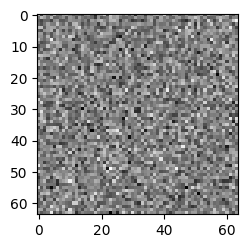

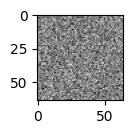

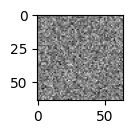

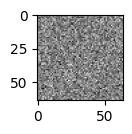

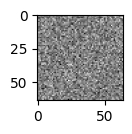

In [67]:
# image = num_to_torch(data_num[12, :])

plot_backward(image, 299, 60)

In [68]:
#see for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu
